In [ ]:
# importing necessary libraries
import pandas as pd
import numpy as np
from bs4 import BeautifulSoup
import requests
import re
from urllib import request

In [ ]:
# Getting the datasets
!wget https://raw.githubusercontent.com/SarthakV7/Kaggle_google_quest_challenge/master/test.csv
!wget https://raw.githubusercontent.com/SarthakV7/Kaggle_google_quest_challenge/master/train.csv

--2020-07-13 14:47:20--  https://raw.githubusercontent.com/SarthakV7/Kaggle_google_quest_challenge/master/test.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 976980 (954K) [text/plain]
Saving to: ‘test.csv’

test.csv            100%[===================>] 954.08K  --.-KB/s    in 0.1s    

2020-07-13 14:47:20 (7.56 MB/s) - ‘test.csv’ saved [976980/976980]



In [ ]:
# Reading the data
train = pd.read_csv('train.csv')
train.head(2)

,qa_id,question_title,question_body,question_user_name,question_user_page,answer,answer_user_name,answer_user_page,url,category,host
0,39,Will leaving corpses lying around upset my pri...,I see questions/information online about how t...,Dylan,https://gaming.stackexchange.com/users/64471,There is no consequence for leaving corpses an...,Nelson868,https://gaming.stackexchange.com/users/97324,http://gaming.stackexchange.com/questions/1979...,CULTURE,gaming.stackexchange.com
1,46,Url link to feature image in the portfolio,I am new to Wordpress. i have issue with Featu...,Anu,https://wordpress.stackexchange.com/users/72927,I think it is possible with custom fields.\n\n...,Irina,https://wordpress.stackexchange.com/users/27233,http://wordpress.stackexchange.com/questions/1...,TECHNOLOGY,wordpress.stackexchange.com


# For scraping data using external links I used 3 features that were provided in the initial datasets. 'url', 'question_user_page' and 'answer_user_page'.

### URL

#### The link provided in this feature takes us directly to the question page on stackoverflow. On that page I found 3 useful features to scrape-
- The upvote count of the best answer (best answer = answer provided in the dataset) as 'upvotes'.
- The comments in the best answer. (named as comments_0 in the scraped feature dataset).
- The top 3 answers apart from the best answer and their comments. (named as answer_1, comment_1, answer_2, comment_2, answer_3, comment_3 in the scraped feature dataset).

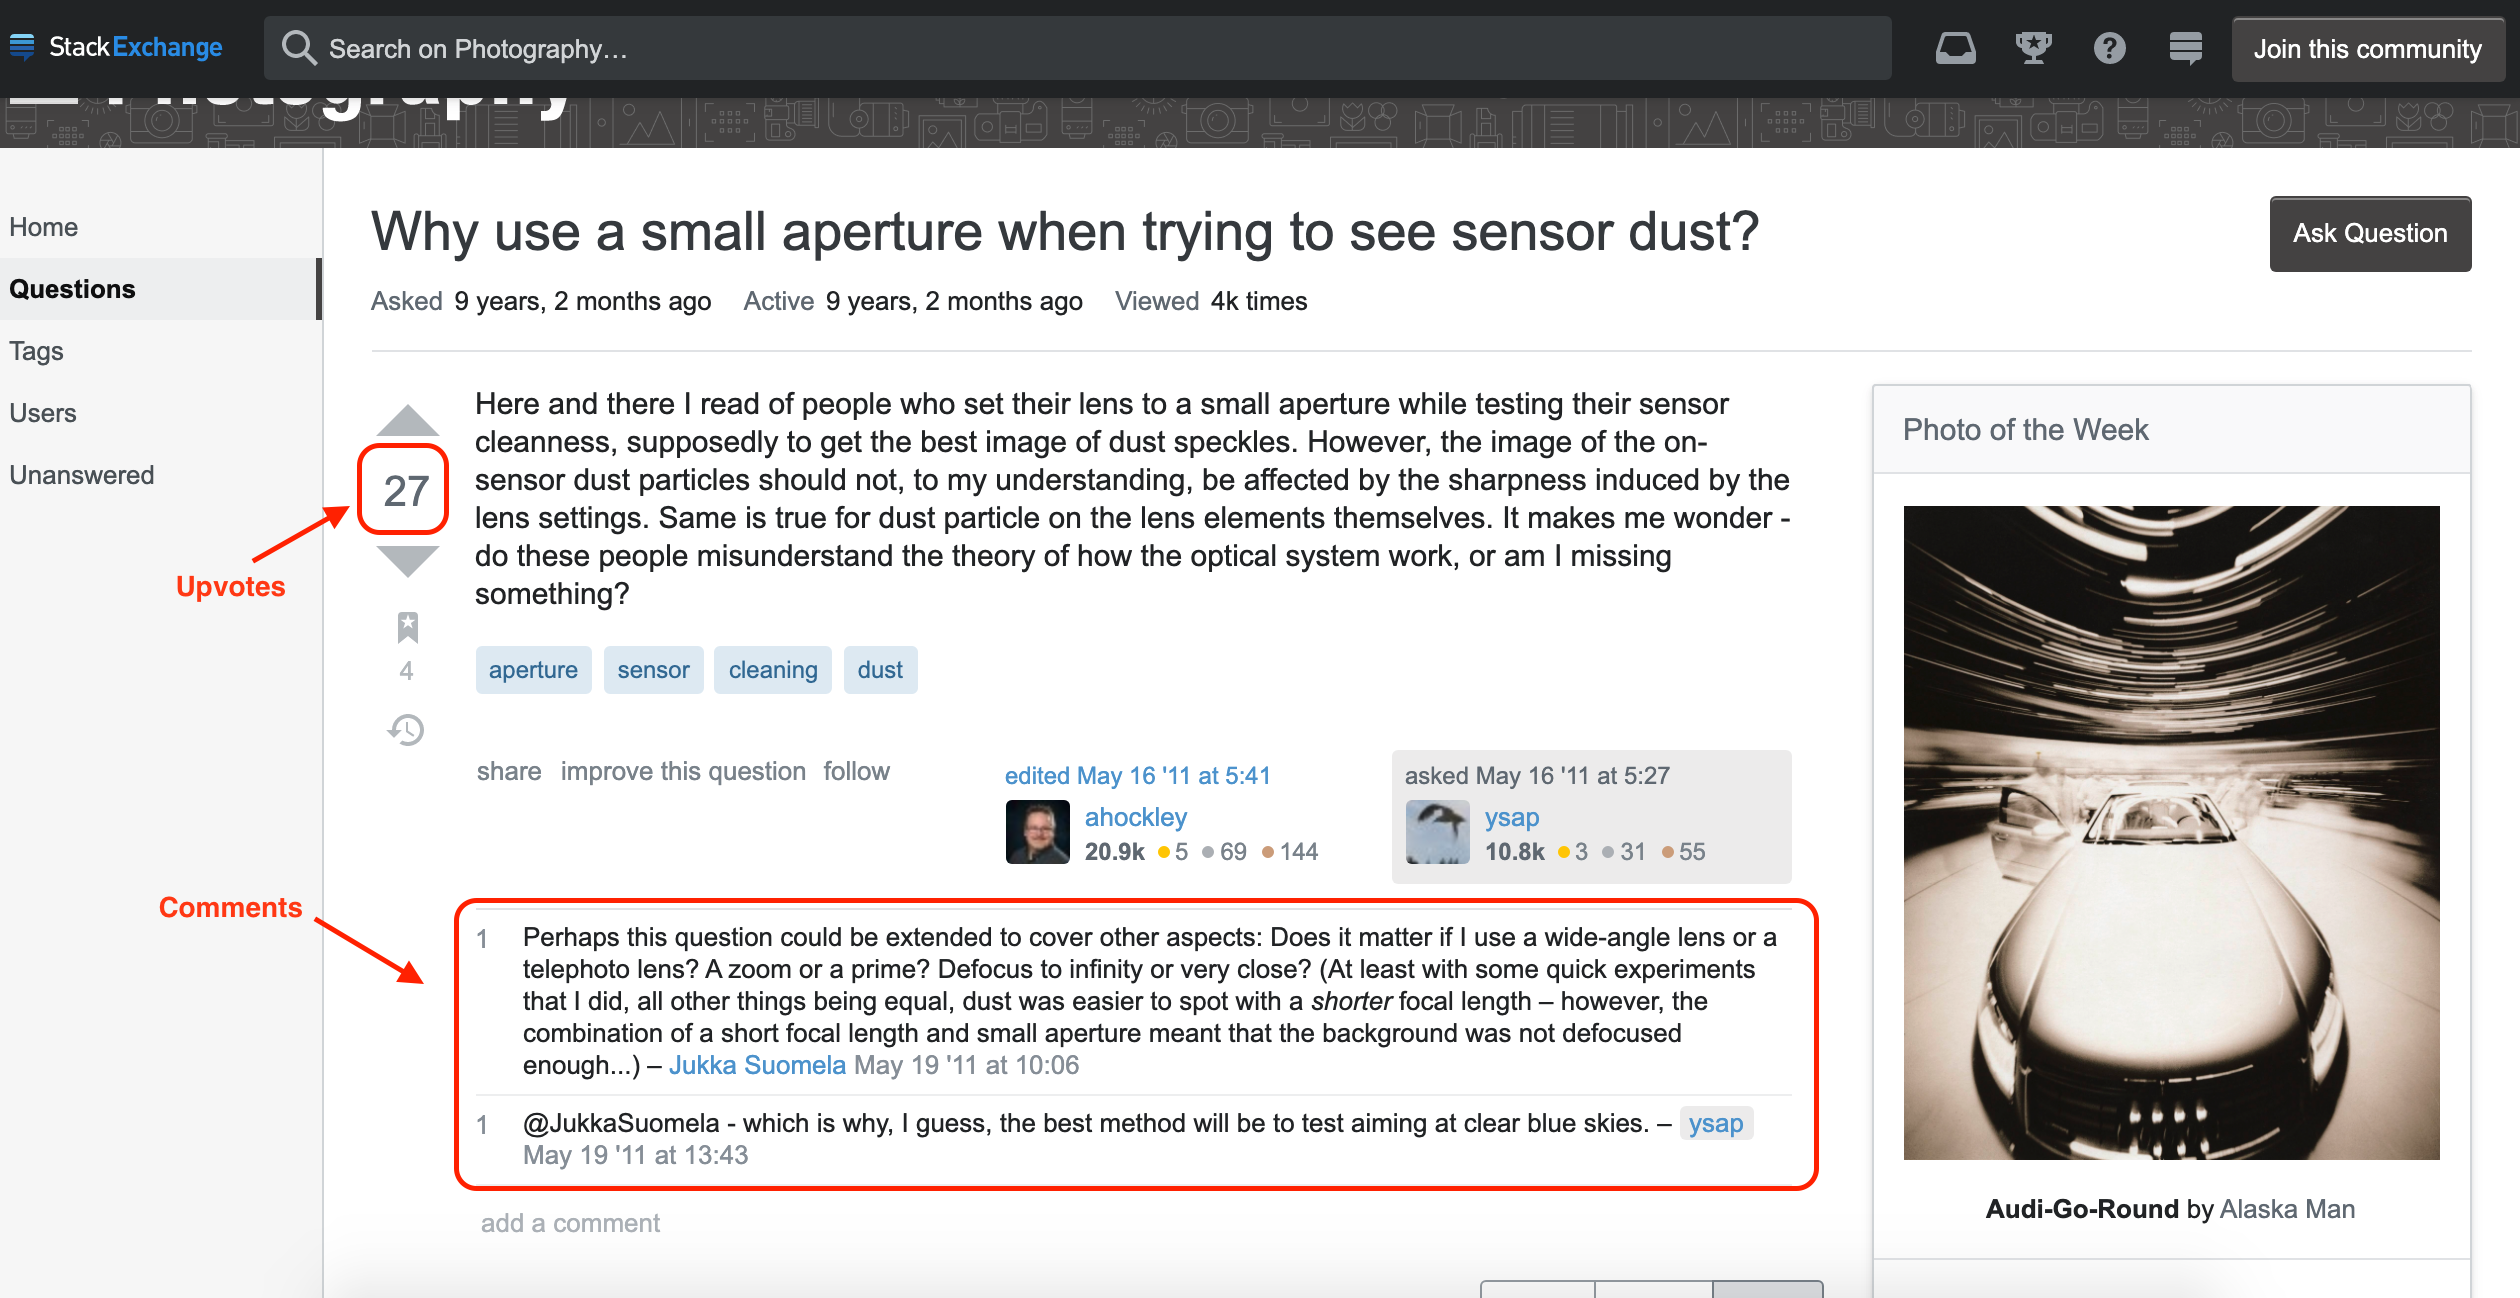

In [3]:
%matplotlib inline
from IPython.display import Image 
Image('2.png', width=920, height=480)

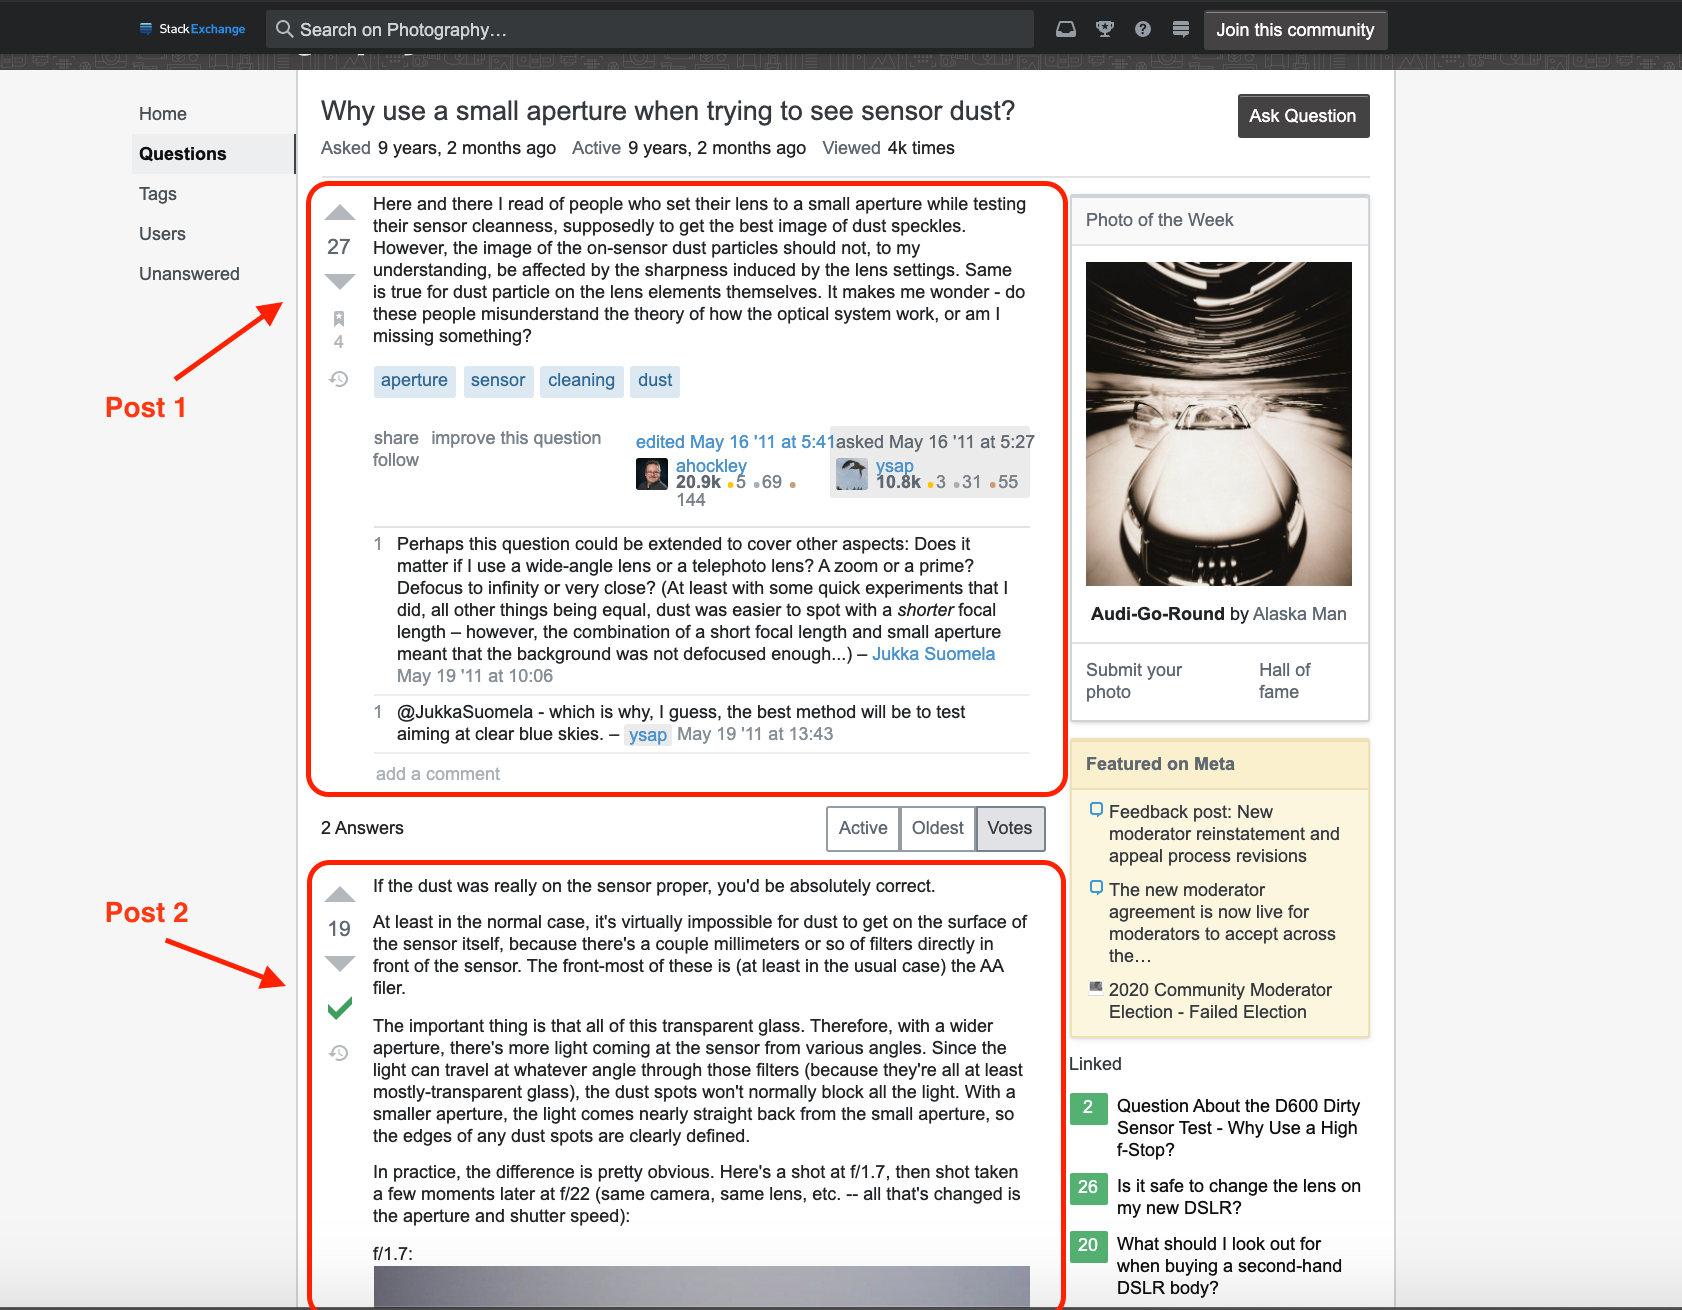

In [6]:
Image('3.png', width=620, height=480)

In [ ]:
# Here is the code. Since all of the urls are of stackoverflow, they have the same html hierarchy.
def get_answers(url):
  try:
    get = request.urlopen(url).read()
    src = BeautifulSoup(get, 'html.parser')
    upvotes, posts = [], []
    correct_ans, comments = [], []
    new_features = []
    post_layout = src.find_all("div", class_ = 'post-layout')
    l = len(post_layout)
    for p in post_layout[:l]:
      posts.append(p.find_all('div', class_='post-text')[0].text.strip())
      upvotes.append(int(p.find_all("div", class_ = 'js-vote-count grid--cell fc-black-500 fs-title grid fd-column ai-center')[0].get('data-value')))
      correct_ans.append(len(p.find_all("div", class_ = 'js-accepted-answer-indicator grid--cell fc-green-500 ta-center py4')))
      comments.append('\n'.join([i.text.strip() for i in p.find_all('span', class_='comment-copy')]))

    idx = np.argmax(correct_ans)
    new_features.append(upvotes.pop(idx))
    new_features.append(comments.pop(idx))
    del posts[idx]
    if l < 3:
      k=l
    else:
      k=3
    for a,b in zip(posts[:k], comments[:k]):
      new_features.append(a)
      new_features.append(b)

    for a,b in zip(posts[:3-k], comments[:3-k]):
      new_features.append('')
      new_features.append('')

    return new_features

  except:
    return [np.nan]*8 # return np.nan if the code runs into some error like page not found

In [ ]:
# Collecting data
from tqdm import tqdm
data = []
for url in tqdm(train['url']):
  data.append(get_answers(url))

In [ ]:
# Saving as dataframe
columns = ['upvotes', 'comments_0', 'answer_1', 'comment_1', 'answer_2', 'comment_2', 'answer_3', 'comment_3']
scraped = pd.DataFrame(lens, columns=columns)
scraped.to_csv(f'scraped_posts.csv', index=False)

### Question_user_page, Answer_user_page

#### The link provided in this feature takes us directly to the user's page on stackoverflow. On that page I found 4 useful features to scrape-
- Reputation of the user.
- Number of gold points achieved by the user.
- Number of silver points achieved by the user.
- Number of bronze points achieved by the user.

These features are stored as reputation_q, reputation_a, gold_q, gold_a, silver_q, silver_a, bronze_q, bronze_a in the dataset (here 'q' corresponds to the data from question user page and 'a' corresponds to the data from answer user page).

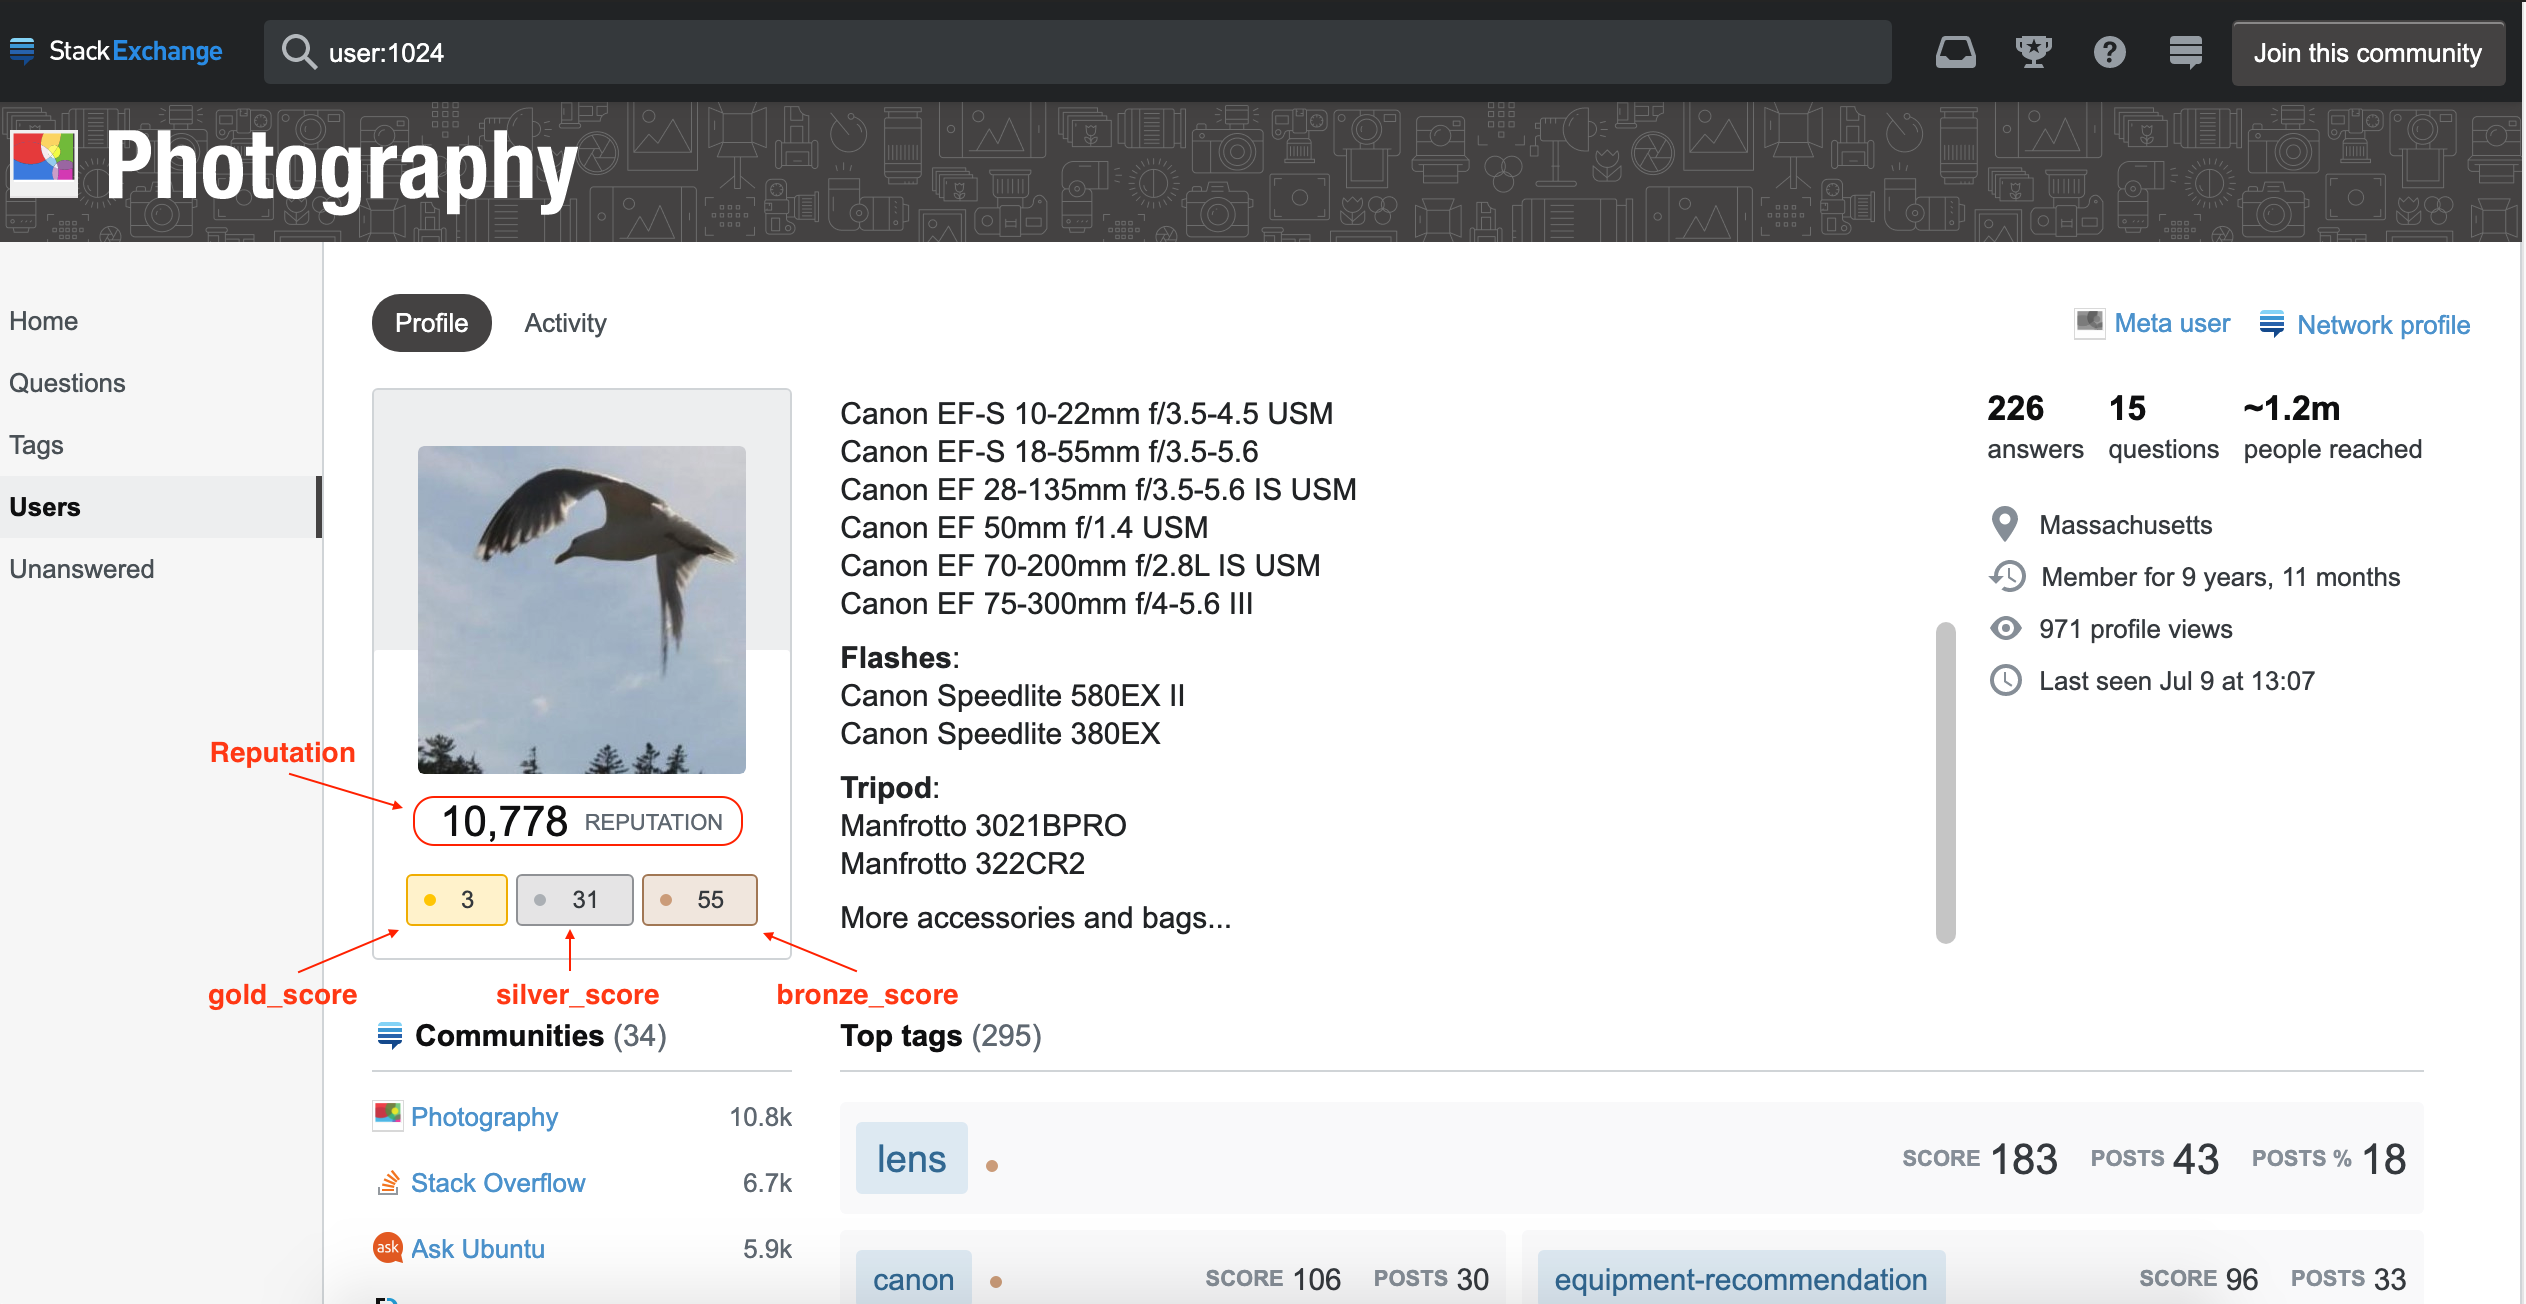

In [8]:
Image('1.png', width=920, height=480)

In [ ]:
# code for scraping the data. Since all of the urls are of stackoverflow, they have the same html hierarchy.
train = pd.read_csv('train.csv')
def get_user_rating(url):
  try:
    get = request.urlopen(url).read()
    src = BeautifulSoup(get, 'html.parser')
    reputation, gold = [], []
    silver, bronze = [], []
    template = src.find_all("div", class_ = 'grid--cell fl-shrink0 ws2 overflow-hidden')[0]
    reputation = int(''.join(template.find_all('div', class_='grid--cell fs-title fc-dark')[0].text.strip().split(',')))
    gold = int(''.join(template.find_all('div', class_='grid ai-center s-badge s-badge__gold')[0].text.strip().split(',')))
    silver = int(''.join(template.find_all('div', class_='grid ai-center s-badge s-badge__silver')[0].text.strip().split(',')))
    bronze = int(''.join(template.find_all('div', class_='grid ai-center s-badge s-badge__bronze')[0].text.strip().split(',')))

    output = [reputation, gold, silver, bronze]
  except:
    output = [np.nan]*4 # return np.nan if the code runs into some error like page not found

  return output

from tqdm import tqdm
data = []
for url in tqdm(train['answer_user_page']):
  data.append(get_user_rating(url))

columns = ['reputation', 'gold', 'silver', 'bronze']
scraped = pd.DataFrame(lens, columns=columns)
scraped.to_csv(f'scraped_score.csv', index=False)

### I collected the data for both train and test datasets.